In [38]:
import scanpy as sc
import pandas as pd
import numpy as np
import torch
import torch_geometric as pyg
from torch_geometric.nn import knn_graph, radius_graph
from torch_geometric.utils import to_undirected

import seaborn as sns

In [2]:
visium_human_DLPFC =  ["../../data/visium/DLPFC/region_1/151674_labeled.h5ad","../../data/visium/DLPFC/region_1/151675_labeled.h5ad"]
merfish_mouse_hypothalamic =  ["../../data/merfish/hypothalamic/merfish_layer1_labeled.h5ad","../../data/merfish/hypothalamic/merfish_layer2_labeled.h5ad"]
stereo_mouse_embryo =  ["../../data/stereo_seq/counts/E15.5/count_E15.5_E1S1_filter_labeled.h5ad","../../data/stereo_seq/counts/E15.5/count_E15.5_E1S2_filter_labeled.h5ad"]

In [33]:
result_dict = {}
for adatas in [visium_human_DLPFC, merfish_mouse_hypothalamic, stereo_mouse_embryo]:
    tech_dict = {}
    if 'visium' and 'DLPFC' in adatas[0]:
        biology_meta = 'cell_type'
        tech = 'Visium'
    elif 'merfish' in adatas[0]:
        biology_meta = 'Cell_class'
        tech = 'MERFISH'
    elif 'stereo' in adatas[0]:
        biology_meta = 'annotation'
        tech = 'Stereo-seq'
    for i, adata in enumerate(adatas):
        print(adata)
        adata1 = sc.read_h5ad(adata)
        edge_index = knn_graph(x=torch.tensor(adata1.obsm['spatial']), flow='source_to_target',
                                k=2, loop=True, num_workers=8)
        edge_index = to_undirected(edge_index)

        adata1_df = pd.DataFrame({'index':range(adata1.shape[0]),
                                'x': adata1.obsm['spatial'][:,0],
                                'y': adata1.obsm['spatial'][:,1],
                                'meta':adata1.obs[biology_meta]})
        source = adata1_df.iloc[edge_index[0],:]
        target = adata1_df.iloc[edge_index[1],:]
        source['meta2'] = target['meta'].tolist().copy()
        print(f'{source.shape[0]} edges')
        ratio = (source['meta'] == source['meta2']).value_counts()[0]/source.shape[0]
        print(ratio)
        tech_dict[f'slice_{i}'] = ratio
    result_dict[tech] = tech_dict
    print('-----------------')

../../data/visium/DLPFC/region_1/151674_labeled.h5ad


/tmp/ipykernel_601993/2544133365.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  source['meta2'] = target['meta'].tolist().copy()
/tmp/ipykernel_601993/2544133365.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  source['meta2'] = target['meta'].tolist().copy()


7883 edges
0.8934415831536218
../../data/visium/DLPFC/region_1/151675_labeled.h5ad
7698 edges
0.8656793972460379
-----------------
../../data/merfish/hypothalamic/merfish_layer1_labeled.h5ad


/tmp/ipykernel_601993/2544133365.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  source['meta2'] = target['meta'].tolist().copy()
/tmp/ipykernel_601993/2544133365.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  source['meta2'] = target['meta'].tolist().copy()


15308 edges
0.6092239351972825
../../data/merfish/hypothalamic/merfish_layer2_labeled.h5ad
15453 edges
0.63113958454669
-----------------
../../data/stereo_seq/counts/E15.5/count_E15.5_E1S1_filter_labeled.h5ad


/tmp/ipykernel_601993/2544133365.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  source['meta2'] = target['meta'].tolist().copy()


230353 edges
0.9426879615199281
../../data/stereo_seq/counts/E15.5/count_E15.5_E1S2_filter_labeled.h5ad
222059 edges
0.9355306472604128
-----------------


/tmp/ipykernel_601993/2544133365.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  source['meta2'] = target['meta'].tolist().copy()


In [50]:
result = pd.DataFrame(result_dict)
result = pd.melt(result.reset_index(), id_vars='index')
result

,index,variable,value
0,slice_0,Visium,0.893442
1,slice_1,Visium,0.865679
2,slice_0,MERFISH,0.609224
3,slice_1,MERFISH,0.631140
4,slice_0,Stereo-seq,0.942688
5,slice_1,Stereo-seq,0.935531


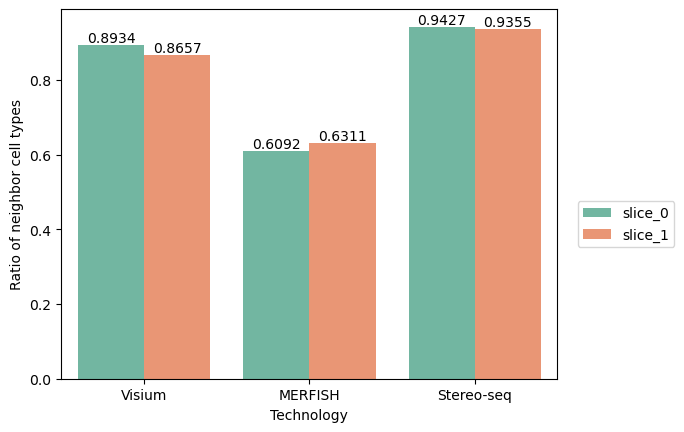

In [79]:
# seaborn grouped barplot
ax = sns.barplot(data=result, x='variable', y='value', hue='index', palette='Set2')
# set x label
ax.set_xlabel('Technology')
ax.set_ylabel('Ratio of neighbor cell types')
ax.legend(bbox_to_anchor = (1.25, 0.5))
for i in ax.containers:
    ax.bar_label(i, fmt='%.4f')